# Step 1: Data Preparation

The raw images have already been processed and saved in the `processed_data` folder. To see the preprocessing, check out `data_processing.ipynb`

We will load the processed images in memory and normalize them to 0 to 1 instead of 0 - 255

In [1]:
import os
from PIL import Image
import numpy as np

#Constants

INPUT_DIR = "data/"
OUTPUT_DIR = "processed_data/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Image Size
TARGET_SIZE = (128, 128)

#Noise vector size
LATENT_DIMS = 100

In [2]:
def load_and_normalize_images(output_dir):
    images = []
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(file_path)
            # Convert image to a NumPy array and normalize to [-1, 1]
            img_array = (np.array(img) - 127.5) / 127.5
            images.append(img_array)
            
    return np.array(images)


images = load_and_normalize_images(OUTPUT_DIR)
print(f"Processed {len(images)} images.")


Processed 150 images.


# Step 2: Model Training

Now that the data is ready, we need to train the models. Eventually, we will only save the generator because the discriminator is only helpful for training

In [3]:
%pip install -q tensorflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2.1: The Discriminator

The Discriminator is a binary classification CNN which will evaluate the generator's output. 

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

def build_discriminator(image_size=128, num_channels=3):
    model = Sequential()

    # Input: (image_size, image_size, num_channels)
    model.add(Conv2D(32, kernel_size=(4,4), strides=2,
                     input_shape=(image_size, image_size, num_channels)))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    # 2nd Convolutional Layer
    model.add(Conv2D(16, kernel_size=(4,4), strides=2))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    #Fully connected
    model.add(Flatten())
    model.add(Dense(32, activation=LeakyReLU(alpha=0.2)))
    # Output layer
    model.add(Dense(1, activation="sigmoid"))  # Output a single probability

    return model

In [7]:
discriminator = build_discriminator()
discriminator.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 16)     │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       460,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 470,641 (1.80 MB)

 Trainable params: 470,641 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

## Step 2.2: The Generator

The Generator will take in random noise and produce the image. Instead of `Conv2D` layers (like in the Discriminator), we will use `Conv2DTranspose` layers

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU

def build_generator(latent_dim=LATENT_DIMS, num_channels=3):
    model = Sequential()


    model.add(Dense(8 * 8 * 64, input_dim=latent_dim)) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 64)))  # Output shape: (8, 8, 64)

    # First upsampling layer
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Second upsampling layer
    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Output layer
    model.add(Conv2DTranspose(num_channels, kernel_size=4, strides=4, padding="same", activation="tanh"))

    return model

In [9]:
generator = build_generator()
generator.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 3)    │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 530,403 (2.02 MB)

 Trainable params: 522,019 (1.99 MB)

 Non-trainable params: 8,384 (32.75 KB)

## Step 2.3: Training

Since we do not have features and labels per se, we cannot just call `model.fit()`. Instead, we need to define our own training loop

In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


class GAN:
    def __init__(self, generator, discriminator, batch_size=32, latent_dims=100):
        self.generator = generator
        self.discriminator = discriminator
        self.BATCH_SIZE = batch_size       
        self.LATENT_DIMS =  latent_dims

        self.discriminator.trainable = False
        self.gan = tf.keras.models.Sequential([self.generator, self.discriminator])

        discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        
        self.gan.compile(
            loss='binary_crossentropy',
            optimizer=generator_optimizer,
        )

        self.discriminator.trainable = True        
        self.discriminator.compile(
            loss='binary_crossentropy',
            optimizer=discriminator_optimizer,
            metrics=['accuracy']
        )
        
        print(self.discriminator._loss_tracker)


    def get_images(self, num_images):
        noise = np.random.normal(0, 1, (num_images, self.LATENT_DIMS))
        images = self.generator.predict(noise, verbose=0)
        return images

    def train_discriminator(self, data):
        self.discriminator.trainable = True
        idx = np.random.randint(0, data.shape[0], self.BATCH_SIZE)
        real_images = data[idx]

        # Generate fake images
        fake_images = self.get_images(self.BATCH_SIZE)
        #Labels
        real_labels = np.ones((self.BATCH_SIZE, 1))
        fake_labels = np.zeros((self.BATCH_SIZE, 1))
        
        # Train the discriminator
        d_loss_real = self.discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = self.discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = np.add(d_loss_real, d_loss_fake)
        
        self.discriminator.trainable = False
        return d_loss
    

    def train_generator(self):
        self.generator.trainable = True
        noise = np.random.normal(0, 1, (self.BATCH_SIZE, self.LATENT_DIMS))
        labels = np.ones((self.BATCH_SIZE, 1)) #All ones so that the fake (0) reflects as loss
        
        g_loss = self.gan.train_on_batch(noise, labels)

        self.generator.trainable = False
        return g_loss
    

    def show_generated_image(self, noise):
        fake_image = self.generator.predict(noise, verbose=0)[0]
        assert(self.generator.weights == self.gan.layers[0].weights)
        fake_image = np.clip((fake_image*127.5)+127.5, 0, 255).astype(np.uint8)  # Denormalize
        plt.imshow(fake_image)
        plt.axis('off')
        plt.show()
        

    def train(self, data, epochs):
        FIXED_LOSS = np.random.normal(0, 1, (1, self.LATENT_DIMS))
        for i in range(epochs):
            disc_loss = self.train_discriminator(data)
            gan_loss = self.train_generator()
            print(f"Epoch {i} completed\n\n")
            #Uncomment the following line to see GAN training progress
            """if i%100 == 0: #Shows results every 100 epochs
                print(f"Discriminator Loss: {disc_loss}")
                print(f"Generator Loss: {gan_loss}")
                self.show_generated_image(FIXED_LOSS)"""

    

In [14]:
gan = GAN(generator, discriminator)

<Mean name=loss>


In [ ]:
gan.train(images, 10000)

Epoch 0 completed


Epoch 1 completed


Epoch 2 completed


Epoch 3 completed


Epoch 4 completed


Epoch 5 completed


Epoch 6 completed


Epoch 7 completed


Epoch 8 completed


Epoch 9 completed


Epoch 10 completed


Epoch 11 completed


Epoch 12 completed


Epoch 13 completed


Epoch 14 completed


Epoch 15 completed


Epoch 16 completed


Epoch 17 completed


Epoch 18 completed


Epoch 19 completed


Epoch 20 completed


Epoch 21 completed


Epoch 22 completed


Epoch 23 completed


Epoch 24 completed


Epoch 25 completed


Epoch 26 completed


Epoch 27 completed


Epoch 28 completed


Epoch 29 completed


Epoch 30 completed


Epoch 31 completed


Epoch 32 completed


Epoch 33 completed


Epoch 34 completed


Epoch 35 completed


Epoch 36 completed


Epoch 37 completed


Epoch 38 completed


Epoch 39 completed


Epoch 40 completed


Epoch 41 completed


Epoch 42 completed


Epoch 43 completed


Epoch 44 completed


Epoch 45 completed


Epoch 46 completed


Epoch 47 completed


Ep

In [ ]:
gan.generator.save("model/generator.keras")

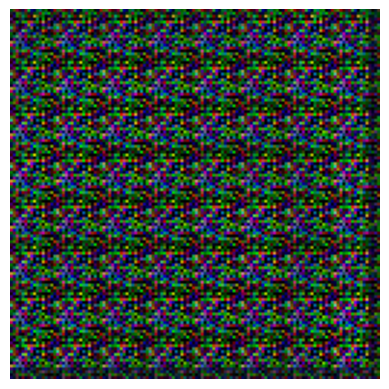

In [ ]:
test_noise = np.random.normal(0, 1, (1, gan.LATENT_DIMS))
gan.show_generated_image(test_noise)